In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9805
meniskus-urgent             9312
cruciate-ligament-urgent    2388
meniskus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64


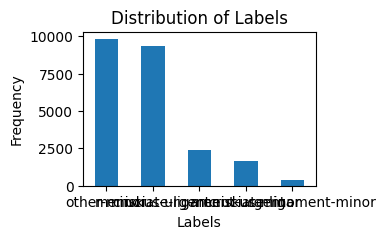

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [3]:
model_name = "layers_more"

In [4]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

2024-07-25 20:55:18.766607: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-25 20:55:18.766633: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-25 20:55:18.766644: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-25 20:55:18.766666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-25 20:55:18.766682: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model definition and training

In [5]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [6]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/15


2024-07-25 20:55:19.677877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


736/736 ━━━━━━━━━━━━━━━━━━━━ 164s 220ms/step - accuracy: 0.4745 - auc: 0.8220 - f1_score: 0.2637 - loss: 1.1391 - val_accuracy: 0.5720 - val_auc: 0.8647 - val_f1_score: 0.3608 - val_loss: 1.0226
Epoch 2/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 160s 217ms/step - accuracy: 0.6278 - auc: 0.8846 - f1_score: 0.4046 - loss: 0.9489 - val_accuracy: 0.6023 - val_auc: 0.8764 - val_f1_score: 0.3865 - val_loss: 0.9849
Epoch 3/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 159s 217ms/step - accuracy: 0.6953 - auc: 0.9181 - f1_score: 0.4883 - loss: 0.8019 - val_accuracy: 0.5940 - val_auc: 0.8731 - val_f1_score: 0.4127 - val_loss: 1.0150
Epoch 4/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 161s 219ms/step - accuracy: 0.7350 - auc: 0.9374 - f1_score: 0.5428 - loss: 0.7009 - val_accuracy: 0.6273 - val_auc: 0.8857 - val_f1_score: 0.4422 - val_loss: 0.9810
Epoch 5/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 159s 216ms/step - accuracy: 0.7821 - auc: 0.9552 - f1_score: 0.5893 - loss: 0.5917 - val_accuracy: 0.6616 - val_auc: 0.8953 - val_f1_score: 0.4711 

In [7]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to models/layers_more/layers_more.h5
Data saved


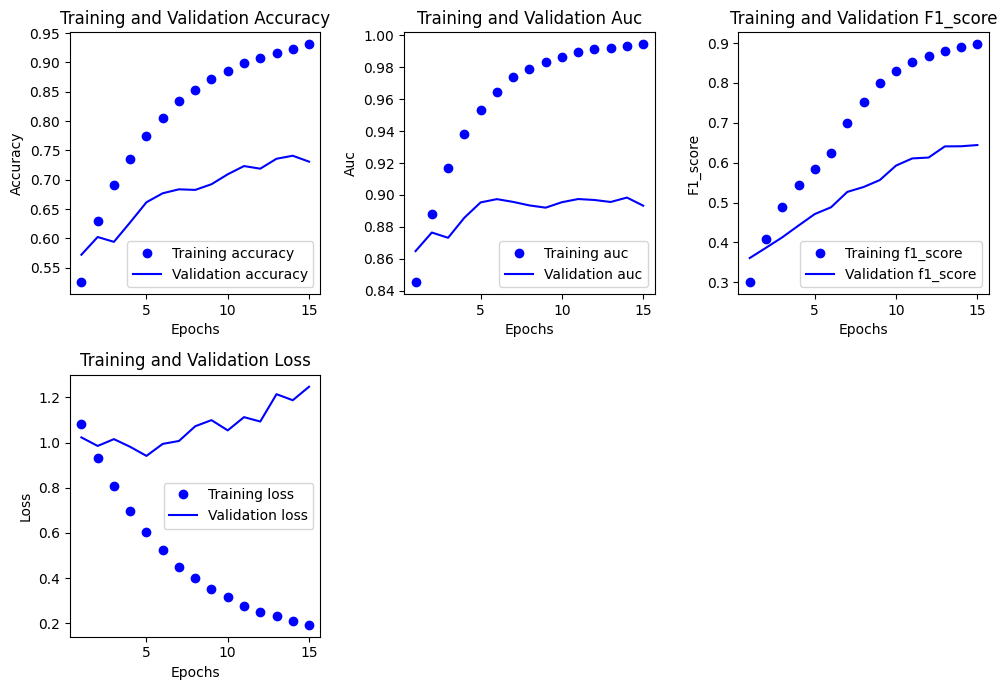

In [8]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 37s 148ms/step


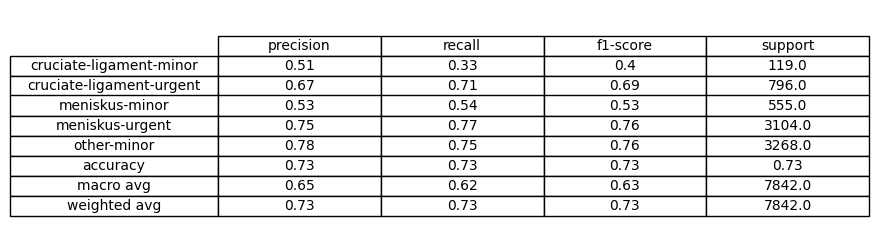

In [9]:
eval(model, test_padded, test_labels, label_encoder)